In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
dataset_path = "bike_data_new.csv"

In [2]:
def process_bike_data(data_file_path):
    start_time = time.time() # record start time

    # Load data into a Pandas dataframe
    df = pd.read_csv(data_file_path)

    # Convert 'started at' and 'ended at' columns to datetime objects
    df['started_at'] = pd.to_datetime(df['started_at'], format='%d-%m-%Y %H:%M')
    df['ended_at'] = pd.to_datetime(df['ended_at'], format='%d-%m-%Y %H:%M')

    # Remove trips of duration 0 minutes
    df = df[df['ended_at'] != df['started_at']]

    # Calculate maximum and minimum duration of the trips
    max_duration = df['ended_at'].sub(df['started_at']).dt.total_seconds().div(60).max()
    min_duration = df['ended_at'].sub(df['started_at']).dt.total_seconds().div(60).min()

    # Calculate the number of trips with the minimum duration
    num_min_duration_trips = df[df['ended_at'].sub(df['started_at']).dt.total_seconds().div(60) == min_duration].shape[0]

    # Calculate the percentage of circular trips
    num_circular_trips = df[df['start_lat'] == df['end_lat']].shape[0]
    pct_circular_trips = num_circular_trips / df.shape[0] * 100

    # Print the results
    print(f"Maximum duration of the trip (in minutes): {max_duration:.2f}")
    print(f"Minimum duration of the trip (in minutes): {min_duration:.2f}")
    print(f"Total number of trips corresponding to the minimum duration: {num_min_duration_trips}")
    print(f"Percentage of total circular trips: {pct_circular_trips:.2f}%")

    end_time = time.time() # record end time
    runtime = end_time - start_time
    print(f"Total runtime: {runtime:.2f} seconds")



process_bike_data(dataset_path)



Maximum duration of the trip (in minutes): 518.00
Minimum duration of the trip (in minutes): 1.00
Total number of trips corresponding to the minimum duration: 89
Percentage of total circular trips: 2.95%
Total runtime: 0.06 seconds


In [3]:
def find_feasible_pairs(data_file_path):
    start_time = time.time() # record start time

    # Load data into a Pandas dataframe
    df = pd.read_csv(data_file_path)

    # Convert 'started at' and 'ended at' columns to datetime objects
    df['started_at'] = pd.to_datetime(df['started_at'], format='%d-%m-%Y %H:%M')
    df['ended_at'] = pd.to_datetime(df['ended_at'], format='%d-%m-%Y %H:%M')

    # Filter trips to include only those starting between 06:00 AM and 06:00 PM
    df = df[(df['started_at'].dt.hour >= 6) & (df['started_at'].dt.hour < 18)]

    # Get a list of unique docking stations
    stations = df[['start_lat', 'start_lng']].drop_duplicates()

    # Initialize counters
    total_pairs = 0

    # Loop over all unique docking stations
    for i in range(len(stations)):
        # Get all trips starting at this docking station
        start_station_trips = df[df['start_lat'] == stations.iloc[i]['start_lat']]

        # Loop over all trips starting at this docking station
        for j in range(len(start_station_trips)):
            # Get the end location of this trip
            end_lat = start_station_trips.iloc[j]['end_lat']
            end_lng = start_station_trips.iloc[j]['end_lng']

            # Get all trips starting at the end location of this trip
            end_station_trips = df[(df['start_lat'] == end_lat) & (df['start_lng'] == end_lng)]

            # Loop over all trips starting at the end location of this trip
            for k in range(len(end_station_trips)):
                # Check if the end time of this trip is greater than or equal to the start time of the next trip
                if end_station_trips.iloc[k]['started_at'] >= start_station_trips.iloc[j]['ended_at']:
                    total_pairs += 1

    # Print the total number of feasible pairs of trips
    print(f"Total feasible pairs of trips: {total_pairs}")

    end_time = time.time() # record end time
    runtime = end_time - start_time
    print(f"Total runtime: {runtime:.2f} seconds")

find_feasible_pairs(dataset_path)

Total feasible pairs of trips: 51951
Total runtime: 33.83 seconds


In [5]:
dataset = pd.read_csv(dataset_path)
df_subset = dataset.head(100)


In [6]:
unique_depots_lat= pd.concat([df_subset['start_lat'], df_subset['end_lat']]).unique()
unique_depots_lng = pd.concat([df_subset['start_lng'], df_subset['end_lng']]).unique()
num_unique_depots_lat = len(unique_depots_lat)
num_unique_depots_lng = len(unique_depots_lng)
print(num_unique_depots_lat)
print(num_unique_depots_lng)

unique_depots = unique_depots_lat
num_unique_depots = num_unique_depots_lat

136
139


In [7]:
!apt install libspatialindex-dev

!pip install osmnx

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c6 libspatialindex6
The following NEW packages will be installed:
  libspatialindex-c6 libspatialindex-dev libspatialindex6
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 319 kB of archives.
After this operation, 1,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex6 amd64 1.9.3-2 [247 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex-c6 amd64 1.9.3-2 [55.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex-dev amd64 1.9.3-2 [16.0 kB]
Fetched 319 kB in 0s (856 kB/s)
Selecting previously unselected package libspatialindex6:amd64.
(Reading database ... 120831 files and directories currently installed.)
Preparing to unpack .../libspatialindex6_1.9.3-2_amd64.deb ...
Unp

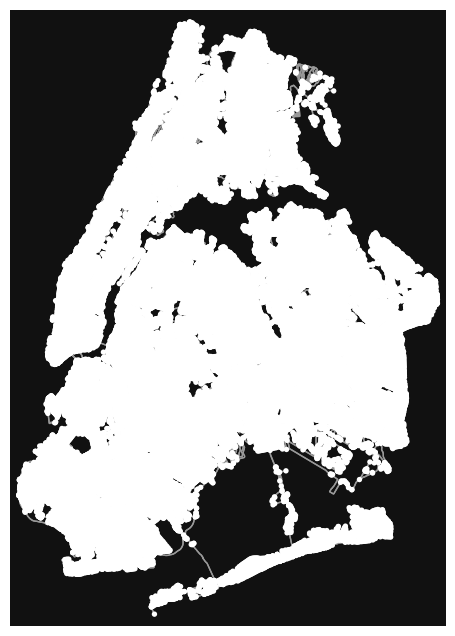

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
import osmnx as ox

import networkx as nx


# download the graph
G = ox.graph_from_place('New York City, New York, USA', network_type='bike')
ox.plot_graph(G)

In [9]:
!pip install scikit-learn

In [12]:
# create a dictionary of depot names and their nearest node in the graph


import sklearn
depot_nodes = {}
for depot in unique_depots:
    matching_rows = df_subset[df_subset['start_lat'] == depot]
    if not matching_rows.empty:
        depot_lat, depot_lon = matching_rows[['start_lat', 'start_lng']].iloc[0]
        node = ox.distance.nearest_nodes(G, depot_lat, depot_lon, return_dist=True)
        depot_nodes[depot] = node
    else:
        print(f"No matching rows found for depot: {depot}")



# find shortest path distances between all pairs of depots
min_distances = []
for i in range(num_unique_depots):
    for j in range(i+1, num_unique_depots):
        try:
            distance = nx.shortest_path_length(G, depot_nodes[unique_depots[i]], depot_nodes[unique_depots[j]], weight='length')
            if distance > 0:
                min_distances.append(distance)
        except:
            pass

# print the results
if len(min_distances) > 0:
    max_distance = max(min_distances)
    min_distance = min(min_distances)
    print("Total runtime:", total_runtime)
    print("Maximum distance (miles):", max_distance)
    print("Minimum distance (miles):", min_distance)
else:
    print("No feasible path found between any pair of depots.")


No matching rows found for depot: 38.906299
No matching rows found for depot: 38.91613685
No matching rows found for depot: 38.935839
No matching rows found for depot: 38.89830174
No matching rows found for depot: 38.908905
No matching rows found for depot: 38.905303
No matching rows found for depot: 38.90571079
No matching rows found for depot: 38.852248
No matching rows found for depot: 38.89696
No matching rows found for depot: 38.863833
No matching rows found for depot: 38.9190185
No matching rows found for depot: 38.817019
No matching rows found for depot: 38.883318
No matching rows found for depot: 38.90980063
No matching rows found for depot: 38.93132186
No matching rows found for depot: 38.91693645
No matching rows found for depot: 38.9121
No matching rows found for depot: 38.90731645
No matching rows found for depot: 38.876695
No matching rows found for depot: 38.93668393
No matching rows found for depot: 38.88081
No matching rows found for depot: 38.92284916
No matching rows 